# Installing and Importing Dependencies

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import math


# Setting Variables

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10 #4 #10
MAX_LEN=512
BATCH_SIZE=16

cuda


# Reading and Preprocessing Data

In [ ]:
# first version:
# df = pd.read_csv('https://gist.githubusercontent.com/stefanerben/998f0be84ae3e483e79cfdfc2c32439d/raw/5c5c1489a13d73df13af0bdc3ab4f2ba82c466e8/comments-rating.csv')[['msg', 'scam']]

df = pd.read_csv('https://gist.githubusercontent.com/stefanerben/8f166d2d285645ac50568eea9324ba05/raw/3cba3c0db042fab4d9c577c8e8c751cca5ee2d0f/comments-rating.csv')
df.head()

,number,scam,msg_length,msg
0,0,1,261,entrepreneurship isn’t easy just like protesti...
1,1,0,4,yup!
2,2,0,3,😂😂😂
3,3,1,366,$babyqj 0x800e9d435dcef7a5d43be2bbc5b5cb280fcd...
4,4,0,80,27 crore 😮😮😮😮 say whattt... you are inspiring ...


In [ ]:
df.shape

(3586, 4)

In [ ]:
class ScamCollectionDataset(Dataset):
    def __init__(self, scam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.scam = scam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        scam = self.scam[i]

        encoding = self.tokenizer.encode_plus(
            msg, 
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'scam': torch.tensor(scam, dtype=torch.long)
        }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ScamCollectionDataset(
        scam=df['scam'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [ ]:
# 80:10:10
df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42
)
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42
)
df_train.shape, df_test.shape, df_val.shape

((2868, 4), (359, 4), (359, 4))

In [ ]:
df_train

,number,scam,msg_length,msg
177,177,1,143,am speechless seeing myself having my first pa...
829,829,0,30,cuando llegara a panamá 🇵🇦🇵🇦🇵🇦
1106,1106,0,49,i saw pasture raised eggs for $10 at one store!!!
2872,2872,0,10,❤️❤️❤️❤️❤️
1869,1869,0,34,the dude are legend in crime lol 😂
...,...,...,...,...
1130,1130,0,36,& zelda inu both saving puppies 🐶 💙🙏
1294,1294,1,227,few people have 👏🏽 the privilege of having suc...
860,860,0,105,you do know that these accounts are handled by...
3507,0,0,23,#Renewable_Energy_Token


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
d = next(iter(train_data_loader))
d.keys()

dict_keys(['msg', 'input_ids', 'attention_mask', 'scam'])

In [ ]:
d['input_ids'].shape, d['attention_mask'].shape, d['scam'].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

# Model Building

In [ ]:
class ScamClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ScamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # self.classifier
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output) # self.classifier

In [ ]:
model = ScamClassifier(n_classes=2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Loss, Optimizer and Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

# Train Model Function

In [ ]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train() # Setting Model in training mode

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device) # [16, 512]
        attention_mask = d['attention_mask'].to(device) # [16, 512]
        targets = d['scam'].to(device) # [16]

        # Forward Propogation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ) # [16, 3]

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward Propogation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clipping Gradient (Exploding Gradient Problem)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # Resetting gradients

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)
    
    return train_acc, train_loss

# Validating Model Function

In [ ]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples   
):
    model = model.eval() # Setting Model in evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device) # [16, 512]
            attention_mask = d['attention_mask'].to(device) # [16, 512]
            targets = d['scam'].to(device) # [16]

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ) # [16, 3]

            # Calculating Loss
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

# Training the Model

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        val_data_loader,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.29755287607096964 accuracy 0.9020223152022315
Validation loss 0.15071221522015074 accuracy 0.958217270194986

Epoch 2/10
----------
Train loss 0.174420117899879 accuracy 0.9501394700139469
Validation loss 0.1626612198660555 accuracy 0.947075208913649

Epoch 3/10
----------
Train loss 0.10021172973146249 accuracy 0.9752440725244073
Validation loss 0.186416065239388 accuracy 0.9554317548746518

Epoch 4/10
----------
Train loss 0.06180856382448433 accuracy 0.9877963737796374
Validation loss 0.20088648945903 accuracy 0.9554317548746518

Epoch 5/10
----------
Train loss 0.045343989123810186 accuracy 0.9905857740585774
Validation loss 0.21728406831844832 accuracy 0.958217270194986

Epoch 6/10
----------
Train loss 0.03250857964643122 accuracy 0.9926778242677824
Validation loss 0.20681085287714782 accuracy 0.9637883008356546

Epoch 7/10
----------
Train loss 0.025976068464579942 accuracy 0.9933751743375174
Validation loss 0.24288701691598955 accuracy 0.96378

# Evaluating the Model Performance

In [ ]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.947075208913649

(0.0, 1.0)

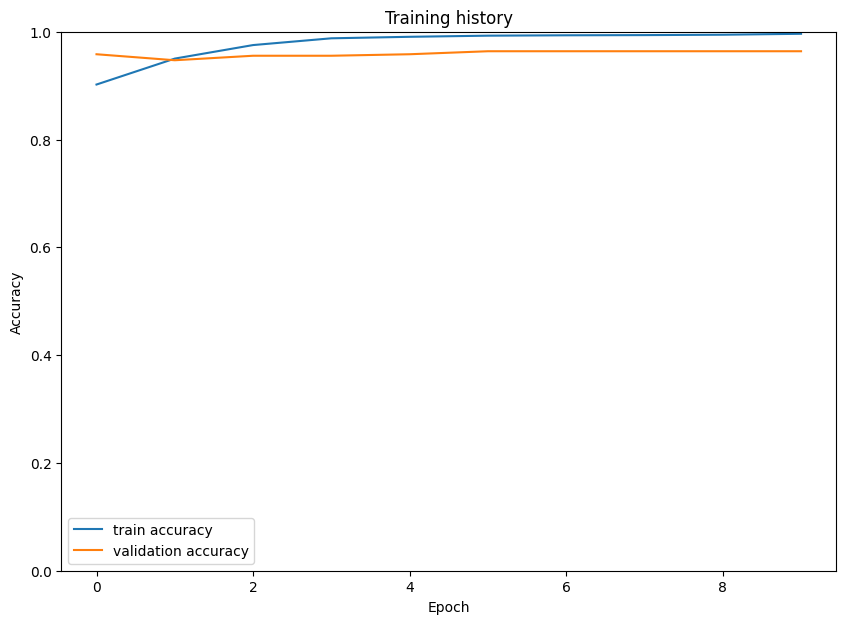

In [ ]:
new_history = defaultdict(list)

new_history['train_acc'] = [ x.cpu() for x in history['train_acc'] ]
new_history['val_acc'] = [ x.cpu() for x in history['val_acc'] ]

plt.figure(figsize=(10, 7))
plt.plot(new_history['train_acc'], label='train accuracy')
plt.plot(new_history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 1])

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            scam = d['scam'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(scam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [ ]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Creating Final Classification Report

In [ ]:
def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    metrices = [accuracy, f1, precision, recall, roc_auc]
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

--------Classification Report---------

                  score
accuracy       0.947075
f1-score       0.924901
precision      0.928571
recall         0.921260
roc auc score  0.941233

--------Plotting Confusion Matrix---------


,score
accuracy,0.947075
f1-score,0.924901
precision,0.928571
recall,0.921260
roc auc score,0.941233


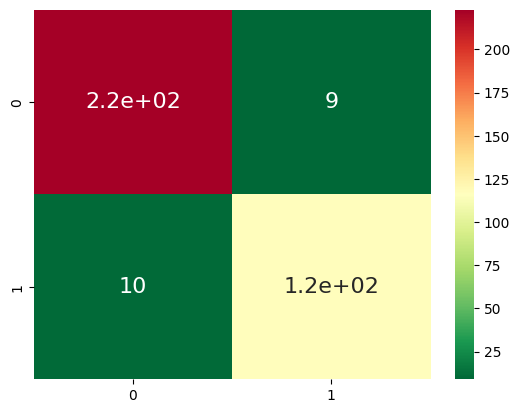

In [ ]:
create_classification_report(y_test, y_pred)

In [ ]:
# Get prediction for a single message
def get_single_prediction(
    model, tokenizer, message
):
    model = model.eval()

    message = tokenizer.encode_plus(
        message,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = message['input_ids'].to(device)
    attention_mask = message['attention_mask'].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, prediction = torch.max(outputs, dim=1)

    return prediction.item()



In [ ]:
#message = "This is a test message"
message = "Invest with our BTC manager"
result = get_single_prediction(model, tokenizer, message)
print(result)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1


In [ ]:

# predict if a message is scam or not
def predict_scam(model, msg):
    model = model.eval()
    msg = [msg]
    encoding = tokenizer.encode_plus(
        msg,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    output = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, prediction = torch.max(output, dim=1)

    return prediction.item()

# Predicting if a message is scam or not
msg = "Waking up every day to see my balance increased is the best ever happended to me. Thank you so much @harry87"
result = predict_scam(model, msg)
print(result)

0


In [ ]:
data_example = [
    ["Hi this is a test", 0],
    ["Santos coin follow", 0],
    ["Resources Elon! Mars or Bust?", 0],
    ["This seems dumb. So let’s say I’m an individual who wants to go get the Bitcoins, I have to pay to be taken to the moon, then I can’t just go off on my own to find them, I have to pay to be taken there with a suit, a crew, vehicles and all that. Then they would’ve taken multiple others who have also payed to be taken there at the same time. I don’t get it. Seems weird 😂", 0],
    ["What's a king to a god, what's a god to a non beliver, who don't belive in..", 0],
    ["HI EVERYONE 𝒊𝒏 𝒍𝒂𝒔𝒕 1 𝒘𝒆𝒆𝒌 𝑰 𝒉𝒂𝒗𝒆 𝒎𝒂𝒅𝒆 𝒐𝒗𝒆𝒓 $29,000 𝒘𝒊𝒕𝒉 𝒋𝒖𝒔𝒕 𝒂𝒏 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒐𝒇 $1,300, 𝒊𝒕'𝒔 𝒂𝒄𝒕𝒖𝒂𝒍𝒍𝒚 𝒎𝒚 𝒇𝒊𝒓𝒔𝒕 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒐𝒏𝒍𝒊𝒏𝒆 𝒕𝒓𝒂𝒅𝒆 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒂𝒏𝒅 𝒂𝒎 𝒈𝒍𝒂𝒅 𝑰 𝒆𝒂𝒓𝒏𝒆𝒅 𝒂𝒍𝒍 𝒕𝒉𝒂𝒏𝒌𝒔 𝒕𝒐 @invest_with_danielle_d entrepreneur 𝒂𝒏𝒅 her 𝒕𝒓𝒂𝒅𝒊𝒏𝒈 𝒕𝒆𝒂𝒎", 1],
    ["Waking up every day to see my balance increased is the best ever happended to me. Thank you so much @harry87", 1],
    ["Good reviews ofdaily from her techniques Almost €30,000 within the week payout on week days feels better @staci.elmafx", 1]
    ]
df_example = pd.DataFrame(data_example, columns=['msg', 'scam'])
example_data_loader = create_data_loader(df_example, tokenizer, MAX_LEN, BATCH_SIZE)

y_ex_msgs, y_ex_pred, y_ex_pred_probs, y_ex_test = get_predictions(
  model,
  example_data_loader
)

for x in range(len(y_ex_msgs)): 
  print(round(y_ex_pred_probs[x][1].item(), 4), y_ex_msgs[x])

#print(y_ex_msgs)
#print(y_ex_pred[2].item())
#print(y_ex_pred_probs[2][1])
#print(y_ex_test)


0.0001 Hi this is a test
0.0001 Santos coin follow
0.0036 Resources Elon! Mars or Bust?
0.0041 This seems dumb. So let’s say I’m an individual who wants to go get the Bitcoins, I have to pay to be taken to the moon, then I can’t just go off on my own to find them, I have to pay to be taken there with a suit, a crew, vehicles and all that. Then they would’ve taken multiple others who have also payed to be taken there at the same time. I don’t get it. Seems weird 😂
0.0001 What's a king to a god, what's a god to a non beliver, who don't belive in..
0.9999 HI EVERYONE 𝒊𝒏 𝒍𝒂𝒔𝒕 1 𝒘𝒆𝒆𝒌 𝑰 𝒉𝒂𝒗𝒆 𝒎𝒂𝒅𝒆 𝒐𝒗𝒆𝒓 $29,000 𝒘𝒊𝒕𝒉 𝒋𝒖𝒔𝒕 𝒂𝒏 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒐𝒇 $1,300, 𝒊𝒕'𝒔 𝒂𝒄𝒕𝒖𝒂𝒍𝒍𝒚 𝒎𝒚 𝒇𝒊𝒓𝒔𝒕 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒐𝒏𝒍𝒊𝒏𝒆 𝒕𝒓𝒂𝒅𝒆 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒂𝒏𝒅 𝒂𝒎 𝒈𝒍𝒂𝒅 𝑰 𝒆𝒂𝒓𝒏𝒆𝒅 𝒂𝒍𝒍 𝒕𝒉𝒂𝒏𝒌𝒔 𝒕𝒐 @invest_with_danielle_d entrepreneur 𝒂𝒏𝒅 her 𝒕𝒓𝒂𝒅𝒊𝒏𝒈 𝒕𝒆𝒂𝒎
0.9989 Waking up every day to see my balance increased is the best ever happended to me. Thank you so much @harry87
0.9998 Good reviews ofdaily from her techniques Almost €30,000 within the week payout on w

# Save model

In [ ]:
#torch.save(model.state_dict(), "model_saved.pt")
# already saved automatically

#Load model

In [ ]:
# device = torch.device('cpu')
device_loaded = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_loaded = ScamClassifier(n_classes=2)
model_loaded = model_loaded.to(device_loaded)
model_loaded.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_attentions=True, output_hidden_states=True)

model_loaded.load_state_dict(torch.load("best_model_state.bin", map_location=device_loaded))
tokenizer_loaded = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

model_loaded.to(device_loaded) # Add this line to move the model to the specified device



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight

ScamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
def create_data_loader_loaded(df, tokenizer_loaded, max_len, batch_size):
    ds = ScamCollectionDataset(
        scam=df['scam'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer_loaded,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [ ]:
def get_predictions_loaded(model_loaded, data_loader_loaded):
    model_loaded = model_loaded.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader_loaded:
            msg = d['msg']
            input_ids = d['input_ids'].to(device_loaded)
            attention_masks = d['attention_mask'].to(device_loaded)
            scam = d['scam'].to(device_loaded)

            outputs = model_loaded(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(scam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [ ]:
data_example_loaded = [
    ["Hi this is a test", 0],
    ["Santos coin follow", 0],
    ["Resources Elon! Mars or Bust?", 0],
    ["This seems dumb. So let’s say I’m an individual who wants to go get the Bitcoins, I have to pay to be taken to the moon, then I can’t just go off on my own to find them, I have to pay to be taken there with a suit, a crew, vehicles and all that. Then they would’ve taken multiple others who have also payed to be taken there at the same time. I don’t get it. Seems weird 😂", 0],
    ["What's a king to a god, what's a god to a non beliver, who don't belive in..", 0],
    ["HI EVERYONE 𝒊𝒏 𝒍𝒂𝒔𝒕 1 𝒘𝒆𝒆𝒌 𝑰 𝒉𝒂𝒗𝒆 𝒎𝒂𝒅𝒆 𝒐𝒗𝒆𝒓 $29,000 𝒘𝒊𝒕𝒉 𝒋𝒖𝒔𝒕 𝒂𝒏 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒐𝒇 $1,300, 𝒊𝒕'𝒔 𝒂𝒄𝒕𝒖𝒂𝒍𝒍𝒚 𝒎𝒚 𝒇𝒊𝒓𝒔𝒕 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒐𝒏𝒍𝒊𝒏𝒆 𝒕𝒓𝒂𝒅𝒆 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒂𝒏𝒅 𝒂𝒎 𝒈𝒍𝒂𝒅 𝑰 𝒆𝒂𝒓𝒏𝒆𝒅 𝒂𝒍𝒍 𝒕𝒉𝒂𝒏𝒌𝒔 𝒕𝒐 @invest_with_danielle_d entrepreneur 𝒂𝒏𝒅 her 𝒕𝒓𝒂𝒅𝒊𝒏𝒈 𝒕𝒆𝒂𝒎", 1],
    ["Waking up every day to see my balance increased is the best ever happended to me. Thank you so much @harry87", 1],
    ["Good reviews ofdaily from her techniques Almost €30,000 within the week payout on week days feels better @staci.elmafx", 1]
    ]
df_example_loaded = pd.DataFrame(data_example_loaded, columns=['msg', 'scam'])
example_data_loader_loaded = create_data_loader_loaded(df_example_loaded, tokenizer_loaded, MAX_LEN, BATCH_SIZE)

y_ex_msgs, y_ex_pred, y_ex_pred_probs, y_ex_test = get_predictions_loaded(
  model_loaded,
  example_data_loader_loaded
)

for x in range(len(y_ex_msgs)): 
  print(round(y_ex_pred_probs[x][1].item(), 4), y_ex_msgs[x])

#print(y_ex_msgs)
#print(y_ex_pred[2].item())
#print(y_ex_pred_probs[2][1])
#print(y_ex_test)


0.0006 Hi this is a test
0.0004 Santos coin follow
0.0373 Resources Elon! Mars or Bust?
0.4373 This seems dumb. So let’s say I’m an individual who wants to go get the Bitcoins, I have to pay to be taken to the moon, then I can’t just go off on my own to find them, I have to pay to be taken there with a suit, a crew, vehicles and all that. Then they would’ve taken multiple others who have also payed to be taken there at the same time. I don’t get it. Seems weird 😂
0.0008 What's a king to a god, what's a god to a non beliver, who don't belive in..
0.9996 HI EVERYONE 𝒊𝒏 𝒍𝒂𝒔𝒕 1 𝒘𝒆𝒆𝒌 𝑰 𝒉𝒂𝒗𝒆 𝒎𝒂𝒅𝒆 𝒐𝒗𝒆𝒓 $29,000 𝒘𝒊𝒕𝒉 𝒋𝒖𝒔𝒕 𝒂𝒏 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒐𝒇 $1,300, 𝒊𝒕'𝒔 𝒂𝒄𝒕𝒖𝒂𝒍𝒍𝒚 𝒎𝒚 𝒇𝒊𝒓𝒔𝒕 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒐𝒏𝒍𝒊𝒏𝒆 𝒕𝒓𝒂𝒅𝒆 𝒊𝒏𝒗𝒆𝒔𝒕𝒎𝒆𝒏𝒕 𝒂𝒏𝒅 𝒂𝒎 𝒈𝒍𝒂𝒅 𝑰 𝒆𝒂𝒓𝒏𝒆𝒅 𝒂𝒍𝒍 𝒕𝒉𝒂𝒏𝒌𝒔 𝒕𝒐 @invest_with_danielle_d entrepreneur 𝒂𝒏𝒅 her 𝒕𝒓𝒂𝒅𝒊𝒏𝒈 𝒕𝒆𝒂𝒎
0.9953 Waking up every day to see my balance increased is the best ever happended to me. Thank you so much @harry87
0.9995 Good reviews ofdaily from her techniques Almost €30,000 within the week payout on w